# Laboratoire 1 - Prétraitement des données et classification de critiques de film

Patrice Béchard, Soufiane Lamghari

INF6953I - Fouille de données - E18

### Importe tous les modules nécessaires

### Cellule qui installe les modules necessaires.

In [ ]:
!pip install --user sklearn
!pip install --user scipy
!pip install --user gensim
!pip install --user nltk
!pip install --user smart_open
!pip install --user progressbar2
!pip install --user testfixtures

__IMPORTANT__: Redemarrez le notebook apres avoir execute cette cellule!

In [1]:
from __future__ import print_function

import locale, random, glob, urllib, tarfile, sys, os, datetime, multiprocessing
import numpy as np
from time import time, clock
from pprint import pprint;
from math import floor;

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1

from collections import OrderedDict, namedtuple

cores = multiprocessing.cpu_count()

from smart_open import smart_open
try:
    from nltk.tokenize import word_tokenize
    from nltk.stem.snowball import SnowballStemmer
except:
    import nltk
    nltk.download("punkt")
    nltk.download('stopwords')
    from nltk.tokenize import word_tokenize
    from nltk.stem.snowball import SnowballStemmer

import progressbar

# fix random seed for reproducibility
np.random.seed(1)

# Téléchargement des données

Cette cellule télécharge le dataset ImDB Sentiment de Stanford. Remplacez le root_path par le path où vous voulez télécharger les données. Un prétraitement très rapide a été effectué pour remplacer les balises <*br /> par des espaces.

In [2]:
# Enlevez les balises html et séparez les ponctuations du texte
def normalize_text(text):
    # Remplacez les balises par des espaces ici
    norm_text = text.replace('<br />', ' ')
    return norm_text

In [3]:
root_path = './data/'

dirname = 'aclImdb'
filename = 'aclImdb_v1.tar.gz'
dirpath = os.path.join(root_path,'imdb/')
filepath = os.path.join('./imdb/', filename)
urlpath = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

if sys.version > '3':
    control_chars = [chr(0x85)]
else:
    control_chars = [unichr(0x85)]

if not os.path.exists('./imdb/'):
    os.makedirs('./imdb/')

start = clock()

if not os.path.isfile(dirname+'/alldata-id.txt'):
    if not os.path.isdir(dirname):
        if not os.path.isfile(filepath):
            # Download IMDB archive
            print("Downloading IMDB archive...")
            urllib.request.urlretrieve(urlpath, filepath);
        print("Extracting IMDB archive...")
        tar = tarfile.open(filepath, mode='r')
        tar.extractall()
        tar.close()

    # Concatenate and normalize test/train data
    print("Cleaning up dataset...")
    folders = ['train/pos', 'train/neg', 'test/pos', 'test/neg', 'train/unsup']
    alldata = u''
    for fol in folders:
        temp = u''
        output = fol.replace('/', '-') + '.txt'
        # Is there a better pattern to use?
        txt_files = glob.glob(os.path.join(dirname, fol, '*.txt'))
        for txt in txt_files:
            with smart_open(txt, "rb") as t:
                t_clean = t.read().decode("utf-8")
                for c in control_chars:
                    t_clean = t_clean.replace(c, ' ')
                temp += t_clean
            temp += "\n"
        temp_norm = normalize_text(temp)
        with smart_open(os.path.join(dirname, output), "wb") as n:
            n.write(temp_norm.encode("utf-8"))
        alldata += temp_norm

    with smart_open(os.path.join(dirname, 'alldata-id.txt'), 'wb') as f:
        for idx, line in enumerate(alldata.splitlines()):
            num_line = u"{1}\n".format(idx, line)
            f.write(num_line.encode("utf-8"))
else:
    print('The data has already been downloaded')
            
end = clock()
print ("Total running time: ", end-start)

The data has already been downloaded
Total running time:  0.00030599999999991745


# Ouverture des données

In [4]:
with smart_open(os.path.join(dirname, 'alldata-id.txt'), 'rb') as alldata:
    alldata = alldata.readlines()
    X_unsup = []
    X_train = []
    X_test = []
    for line_no, line in enumerate(alldata):
        if line_no // 25000 < 1:
            X_train.append(line.decode("utf-8"))
        elif line_no // 25000 < 2:
            X_test.append(line.decode("utf-8"))   
        else:
            X_unsup.append(line.decode("utf-8"))
        
y_train = [1.0]*12500 + [0.0]*12500
y_test = [1.0]*12500 + [0.0]*12500

# Prétraitement

### Tokenizer

Le prétraitement des données est une étape importante, en particulier lorsque vous travaillez avec du texte. Dans la science des données, c'est très souvent la tâche qui demande le plus de temps. Comme vous l'aurez compris, le but du laboratoire est d'étudier l'influence du prétraitement sur la performance. 

La fonction ci-dessous est ce que l'on appelle un "tokenizer", son but est de créer une liste de "tokens" à partir d'une phrase (single string). Le tâche peut sembler triviale à première vue, mais l'on peut vite s'apercevoir qu'elle ne l'est pas tant (ex: "It's the student's notebook." -> ['It', 'is', 'the', 'sutdent, 'notebook', '.'] ou ["It's", "the", "student's", "notebook."] ?).

En plus du tokenizer, il est possible de rajouter un stemmer qui extrait la racine des mots (ex: "generously" -> "generous")

In [5]:
'''
Parameters:
    use_nltk_tok(bool): either to use nltk word tokenizer (True) or basic space split (False)
    use_stemmer(bool): either to use the nltk stemmer (takes the root of each word)
'''

class custom_tokenizer():
    def __init__(self, use_nltk_tok=False, use_stemmer=False):
        self.use_nltk_tok = use_nltk_tok
        self.use_stemmer = use_stemmer
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)
        
    def __call__(self, string):
        # Utilisez le tokenizer de nltk
        if self.use_nltk_tok:
            tokens = word_tokenize(string)
        # Séparez simplement les mots par les espaces
        else:
            tokens = string.split(' ')
        # 
        if self.use_stemmer:
            words = [self.stemmer.stem(token) for token in tokens]
        else:
            words = tokens
        return words

### Feature Extraction

Le texte est ce que l'on appelle une donnée non structurée, c'est à dire qu'il ne possède pas d'attribut ("feature") fixe et mesurable. Or pour la majorité des algorithmes d'appentissage il est nécessaire d'avoir des vecteurs de même dimension en entrée. Ci-dessous se trouve donc l'extracteur de features, qui transforme toutes les phrases d'un corpus en vecteurs de même dimension. 

L'extraction de feature pour le texte est encore un sujet de recherche, mais quelques méthodes existantes sont déjà relativement efficaces. Les méthodes étudiées durant ce laboratoire sont l'approche Bag-of-Word et Doc2Vec.

__QUESTION 1__:
Faites une petite recherche de littérature sur ces méthodes et expliquez-les avec vos mots (5-10 lignes par méthode). Une bonne piste de départ sont les articles https://arxiv.org/pdf/1301.3781.pdf et https://machinelearningmastery.com/gentle-introduction-bag-words-model/

**BAG OF WORDS** : 

Bag-of-Word est une méthode simple et populaire qui permet de représenter des données textuelles par des vecteurs caractéristiques qu’on peut utiliser comme entrées ou sorties d’algorithmes d’apprentissage automatique. La représentation de la méthode consiste à décrire uniquement *l'occurrence de mots dans un document* (nombre d'occurence, fréquence, tf-idf, ...). Pour ce faire, la méthode définit à la fois un vocabulaire de mots connus et une mesure de leurs présences et c’est en faite selon la manière de concevoir ce vocabulaire qu’on détermine le niveau de complexité de Bag-of-Word. Par contre la méthode Bag-of-Word *ne traite pas les emplacements des mots* connus dans le document, ainsi elle ignore toute information sur l'ordre ou la structure des mots dans le document. 

Avec Bag-of-Word, les nouveaux documents qui peuvent contenir des mots en dehors du vocabulaire peuvent toujours être représentés en notant seulement les mots connus et en ignorant ceux qui sont inconnus (ou en les assignant à un *token* spécial `<UNK>`. Il faut savoir aussi que lorsque le vocabulaire est d’une grande taille, on a comme résultats des vecteurs épars qui nécessitent plus de mémoire et de ressources de calcul lors de la modélisation notamment avec les algorithmes traditionnels. Devant cette contrainte on se trouve souvent dans le besoin de diminuer la taille du vocabulaire, et pour répondre à ce problème, il existe plusieurs alternatives simples de nettoyage de texte qui peuvent être utilisées dans un premier temps, telles que l'ignorance de la ponctuation, l'ignorance des mots d'arrêt et la réduction des mots à leurs racines ou bien des techniques plus avancées qui créent un vocabulaire de mots groupés

Bien que la méthode Bag-of-Word est assez simple, la qualité des résultats obtenus est très dépendante de la manière de concevoir le vocabulaire et particulièrement sa taille qui a un impact direct sur l’éparsité des représentations (peu d'informations dans un espace représentationnel très grand), un autre élément de la représentation Bag-of-Word qui la rend moins bonne est la perte de l'ordre des mots, ce qui privatise le modèle exploité du contexte et du sens qui peuvent offrir d’importantes informations dans plusieurs cas.


**DOC2VEC** :

Doc2Vec est une méthode simple aussi et qui donne de bons résultats [2]. Cette méthode est basée principalement sur Word2Vec [3] dans laquelle on construit premièrement un vocabulaire à partir des données textes d’entrainement et ensuite on apprend les vecteurs de représentations de mots.
 
Alors que Word2Vec génère des vecteurs caractéristiques pour chaque mot du corpus, Doc2Vec génère des vecteurs caractéristiques pour chaque paragraphe ou document en entier du corpus quelle que soit la longueur du document. En autres termes la méthode Doc2Vec représente le concept d'un document au lieu de représenter le concept d'un mot, et au lieu d'utiliser uniquement des mots pour prédire le mot suivant, on ajoute également un autre vecteur caractéristique qui est unique au document, mais par conséquent cela impose d’avoir une bonne représentation pour prédire les mots dans le document.

En termes d’algorithmes utilisés pour apprentissage, Word2Vec utilise Continuous Bag-of-Word qui prédit les mots à partir de leurs contextes et Skip-Gram qui prédit le contexte en utilisant les mots, il est plus précis mais plus lent, alors que Doc2Vec utilise Distributed Memory et Distributed Bag-of Word ou bien même la version Paragraph Vector de Distributed Bag-of Word qui est similaire un peu a Skip-Gram.

Techniquement, les méthodes Doc2Vec requièrent un ensemble de documents pour l’entrainement. Pour chaque mot on génère un vecteur de mot, et pour chaque document on génère un vecteur de document. Le modèle entraîne également des poids pour une couche cachée Softmax. Dans la phase d'inférence, un nouveau document peut être présenté, et tous les poids sont fixés pour calculer le vecteur du document.


__QUESTION 2__: D'après vous, quels sont les avantages de Doc2Vec face à BoW?

L’un des principaux avantages de Doc2Vec c’est qu’il considère l’ordre des mots et leurs sémantiques offrant ainsi un contexte supplémentaire pour obtenir de meilleurs résultats même en présence de beaucoup de données, ce qui n’est pas le cas de Bag-of-Word qui peut donner une même représentation pour des phrases différentes, dans ce sens Doc2Vec permet une bonne représentation des documents en entier. En plus Doc2Vec n'est pas une méthode monolithique comme Bag-of-Word, il a des variations différentes pour apprentissage, aussi il est utilisé avec d'autres variations comme avec ou sans échantillonnage négatif et avec ou sans softmax hiérarchique lui offrant ainsi plus de flexibilité et de meilleurs résultats.

Doc2Vec avec des variations spécifiques permet également de généraliser à des documents plus longs et il peut apprendre à partir de données non étiquetées et même si Bag-of-n-grams considère l'ordre des mots dans un contexte court, il souffre toujours d'un manque de données et d'une forte dimensionnalité des représentations ce qui ne lui permet pas de bien généraliser.


__QUESTION 3__: Décrivez rapidement qu'est qu'un bigram. En quoi peut-il améliorer les performances?

Un bigram ou 2-gram est une spécification de l’approche générale n-gram, c’est une approche dans laquelle n fait référence au nombre de mots groupés, gram fait référence à chaque mot ou Token et ainsi n-gram désigne une séquence de mots n-Token. En effet un modèle bigram est un modèle dans lequel on crée un vocabulaire de paires de deux mots, cependant seuls les bigrams qui apparaissent dans le corpus sont modélisés et non pas tous les bigrams possibles.

Comme l’approche bigram est simple et assez puissante elle est souvent préférable à un modèle de 1-gram, enfaite un bigram améliore les performances car il modifie à la fois la portée du vocabulaire et permet de capturer plus de sens du document.


### Extracteur

In [6]:
'''
Parameters:
    X_unsup(list): list of sentences (str) with no label
    X_train(list): list of sentences (str) of the training set
    X_test(list): list of sentences (str) of the test set
    use_Doc2Vec(bool): either to use Doc2Vec (True) or Bag-of-words (False)
    use_bigram(bool): either to create bigrams with the most common sequence of two words (ex: ['New', 'York'] -> ['New_York'])
    use_nltk_tok(bool): either to use nltk word tokenizer (True) or basic space split (False)
    use_stemmer(bool): either to use the nltk stemmer (takes the root of each word)
'''

def prepare_data(X_unsup, X_train, X_test, use_Doc2Vec=False, use_bigram=False, use_nltk_tok=False, use_stemmer=False):
    
    X =  X_test + X_train + X_unsup
    
    kwargs = {"use_nltk_tok":use_nltk_tok, "use_stemmer":use_stemmer}
    tokenizer = custom_tokenizer(**kwargs)
    
    if use_Doc2Vec:
        
        SentimentDocument = namedtuple('SentimentDocument', 'words tags')
        
        print('Creating the docs for Doc2Vec...')
        allreviews = []
        for review in X:
            words = tokenizer(review)
            allreviews.append(words)
        
        if use_bigram:
            print('Training bigram transormer...')
            phrases = Phrases(allreviews)
            bigram = Phraser(phrases)
            # Apellez bigram pour chaque review de la liste allreviews. 
            # Il va permettre de remplacer les couples de mots qui reviennent souvent par un seul token
            allreviews = [bigram[review] for review in allreviews]
        
        alldocs = []
        for line_no, words in enumerate(allreviews):
            tags = [line_no] 
            alldocs.append(SentimentDocument(words, tags))

        # Ici il s'agît de récupérer les documents qui serviront pour le test
        test_docs = alldocs[:len(X_test)]
        # Ici il faut récupérer les documents qui serviront pour l'entraîenement du model
        train_docs = alldocs[len(X_test):]
        
        print('Creating Doc2Vec models...')
        simple_models = [
            # PV-DBOW 
            Doc2Vec(dm=0, vector_size=vec_size, negative=5, hs=0, min_count=2, workers=cores),
            # PV-DM w/ average
            Doc2Vec(dm=1, dm_mean=1, vector_size=vec_size, window=10, negative=5, hs=0, min_count=2, workers=cores),
        ]

        print('Creating a vocabulary...')
        simple_models[0].build_vocab(train_docs)
        for model in simple_models[1:]:
            model.reset_from(simple_models[0])

        models_by_name = OrderedDict((str(model), model) for model in simple_models)
        models_by_name['dbow+dmm'] = ConcatenatedDoc2Vec([simple_models[0], simple_models[1]])

        alpha, min_alpha, passes = (0.025, 0.001, 20)
        alpha_delta = (alpha - min_alpha) / passes
        
        print('Vectorizing the data... %s' % datetime.datetime.now())
        
        print('Starting training...')
        for epoch in range(passes):
            random.shuffle(train_docs)  # Shuffling gets best results

            for name, train_model in models_by_name.items():
                # Train
                train_model.alpha, train_model.min_alpha = alpha, alpha
                train_model.train(train_docs, total_examples=len(train_docs), epochs=1)

            print('Completed pass %i at alpha %f' % (epoch + 1, alpha))
            alpha -= alpha_delta

        print('Vectorization done %s' % str(datetime.datetime.now()))
        
        X_train_vect = np.zeros((len(X_train), vec_size*2))
        X_test_vect = np.zeros((len(X_test), vec_size*2))
        
        # Maintenant remplacez les reviews par leur vecteurs 
        # !!ATTENTION!! Dans le diminuer le biais dans l'expérience, 
        # il faut inferrer les vecteurs pour l'ensemble de test
        print('Inferring vectors...')
        
        for i in range(len(X_train)):
            # Simplement le .docvec du document
            X_train_vect[i,:] = models_by_name['dbow+dmm'].docvecs[len(X_test)+i]
            
            # ici il faut infer_vector depuis le modèle entraîné précédemment
            X_test_vect[i,:] = models_by_name['dbow+dmm'].infer_vector(test_docs[i][0])
    
    else:
        if use_bigram:
            ngram_range = (1,2)
        else:
            ngram_range = (1,1)

        print('Creating a vocabulary...')

        CV = CountVectorizer(analyzer="word", tokenizer=tokenizer, ngram_range=ngram_range, max_features=vocab_size)
        
        CV.fit_transform(X_train + X_unsup)

        vocab = CV.vocabulary_
        stop_words = CV.stop_words_

        print('Vectorizing the data... %s' % datetime.datetime.now())

        CV = CountVectorizer(analyzer="word", ngram_range=ngram_range, tokenizer=custom_tokenizer(**kwargs), preprocessor=lambda text: text.replace("<br />", " "), vocabulary=vocab, stop_words=stop_words)

        X_train_vect = CV.fit_transform(X_train)
        X_test_vect = CV.fit_transform(X_test)

        print('Vectorization done %s' % str(datetime.datetime.now()))
        
    print("Everything done!")
    return X_train_vect, X_test_vect

Ci-dessous, se trouve la ligne à executer pour obtenir les vecteurs à partir de chaque document du corpus. Changez kwargs pour avoir différents prétraitements et feature extracteur.

NB: Certains algorithmes sont plus long que d'autres (si tout est activé), soyez patients.

In [30]:
kwargs = {
    "use_Doc2Vec":True, 
    "use_bigram":False, 
    "use_nltk_tok":False, 
    "use_stemmer":False,
}

vocab_size = None # For the BoW approach. No bound when set to None
vec_size = 10 # For the Doc2Vec approach.

X_train_vec, X_test_vec = prepare_data(X_unsup, X_train, X_test, **kwargs)
n_features = X_train_vec.shape[1]

print('Number of features', n_features)

Creating the docs for Doc2Vec...
Creating Doc2Vec models...
Creating a vocabulary...
Vectorizing the data... 2018-05-18 15:56:55.002278
Starting training...
Completed pass 1 at alpha 0.025000
Completed pass 2 at alpha 0.023800
Completed pass 3 at alpha 0.022600
Completed pass 4 at alpha 0.021400
Completed pass 5 at alpha 0.020200
Completed pass 6 at alpha 0.019000
Completed pass 7 at alpha 0.017800
Completed pass 8 at alpha 0.016600
Completed pass 9 at alpha 0.015400
Completed pass 10 at alpha 0.014200
Completed pass 11 at alpha 0.013000
Completed pass 12 at alpha 0.011800
Completed pass 13 at alpha 0.010600
Completed pass 14 at alpha 0.009400
Completed pass 15 at alpha 0.008200
Completed pass 16 at alpha 0.007000
Completed pass 17 at alpha 0.005800
Completed pass 18 at alpha 0.004600
Completed pass 19 at alpha 0.003400
Completed pass 20 at alpha 0.002200
Vectorization done 2018-05-18 16:18:00.085310
Inferring vectors...
Everything done!
Number of features 20


## Classifieur

Maintenant que les features sont extraits, il faut entraîner un classifieur. Une regression logistique a été choisi pour cette tâche, mais si vous êtes curieux, vous pouvez en essayer d'autres (Les classifieurs simples les plus populaires pour la classification de texte sont: Bayes Naif, SVM linéaire mais vous pouvez choisir autre chose).

N.B.: Ici, un Grid Search avec Cross-Validation a été mit en place pour vous familiariser avec les méthodes d'ensemble qui seront le sujet du laboratoire 2. Il n'est pas nécessaire de le comprendre pour le moment, mais si vous êtes curieux, vous pouvez vous renseigner sur le sujet.

In [7]:
def Classifier(X_train, y_train, X_test, y_test):

    clf = Pipeline([
        ('clf', LogisticRegression())
    ]);

    '''
        Parameters
        ----------
        penalty : string, 'l1' or 'l2' (default='l2')
            Used to specify the norm used in the penalization. The 'newton-cg',
            'sag' and 'lbfgs' solvers support only l2 penalties.
        dual : bool, (default=True)
            Dual or primal formulation. Dual formulation is only implemented for
            l2 penalty with liblinear solver. Prefer dual=False when
            n_samples > n_features.
        tol : float, optional (default=1e-4)
            Tolerance for stopping criteria.
        C : float, optional (default=1.0)
            Inverse of regularization strength; must be a positive float.
            Like in support vector machines, smaller values specify stronger
            regularization.
        fit_intercept : boolean, optional (default=True)
            Specifies if a constant (a.k.a. bias or intercept) should be
            added to the decision function.
        max_iter : int, (default=1000)
            The maximum number of iterations to be run.
        solver : string, {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, (default: 'liblinear')
            Algorithm to use in the optimization problem.
            - For small datasets, 'liblinear' is a good choice, whereas 'sag' and
                'saga' are faster for large ones.
            - For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs'
                handle multinomial loss; 'liblinear' is limited to one-versus-rest
                schemes.
            - 'newton-cg', 'lbfgs' and 'sag' only handle L2 penalty, whereas
                'liblinear' and 'saga' handle L1 penalty.
            Note that 'sag' and 'saga' fast convergence is only guaranteed on
            features with approximately the same scale. You can
            preprocess the data with a scaler from sklearn.preprocessing.
    '''

    parameters = {
#         'clf__penalty': ('l2', 'l1'),
#         'clf__dual':(True, False),
#         'clf__tol':(1e-2, ),
#         'clf__C': (0.1, ),
#         'clf__fit_intercept': (True, False).
        'clf__max_iter':(300,),
#         'solver':('liblinear',)
    }

    grid_search = GridSearchCV(clf, parameters,  verbose=1, iid=True, cv=4, n_jobs=1, return_train_score=False)

    print("Performing grid search...")
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train_vec, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    best_estimator = grid_search.best_estimator_
    score_train = grid_search.best_score_
    print("Best score for validation set : %0.3f" % score_train)
    
    tic= time()
    predictions = best_estimator.predict(X_test_vec);
    print("Prediction done in %0.3fs" % (time() - tic))
    score_test = metrics.accuracy_score(y_test, predictions)
    print("Best score for test set : %0.3f" % score_test)
    print(metrics.classification_report(y_test, predictions, digits=4))
    
    return score_train, score_test

In [31]:
train_score, test_score = Classifier(X_train_vec, y_train, X_test_vec, y_test)

Performing grid search...
parameters:
{'clf__max_iter': (300,)}
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s finished


done in 1.184s

Best score for validation set : 0.853
Prediction done in 0.008s
Best score for test set : 0.849
             precision    recall  f1-score   support

        0.0     0.8241    0.8882    0.8549     12500
        1.0     0.8787    0.8104    0.8432     12500

avg / total     0.8514    0.8493    0.8491     25000



** Dans les questions suivantes, nous avons numéroter les modèles de 1 à 8. Les configurations associées à chaque numéro sont présentées dans la table ci-dessous **

| Numero   | Bigram   | Tokenizer  | Stemmer |
| -------- | -------- | ---------- | ------- |
| 1        | Non      | Non        | Non     |
| 2        | Oui      | Non        | Non     |
| 3        | Non      | Oui        | Non     |
| 4        | Oui      | Oui        | Non     |
| 5        | Non      | Non        | Oui     |
| 6        | Oui      | Non        | Oui     |
| 7        | Non      | Oui        | Oui     |
| 8        | Oui      | Oui        | Oui     |



__QUESTION 4__: Pour l'approche BoW, tracez sur un même graphique les précisions obtenues sur l'ensemble d'entraînement et de test, pour chaque option de prétraitement, en faisant varier la taille du vocabulaire (au moins :1000, 10000, 100000, None). En résumé, un total de 6 courbes avec la précision en y, et la taille du vocabulaire en x). __Commentez les résultats__.

In [8]:
import matplotlib.pyplot as plt

results_dir = './results/'

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [ ]:
# can we have use_nltk_tok=False and use_stemmer=True ? If so, total number of curves is 8

# Les modèles sont numerotés en ordre croissant, de 1 à 8.
configs = [{"use_Doc2Vec":False, "use_bigram":False, "use_nltk_tok":False, "use_stemmer":False},
           {"use_Doc2Vec":False, "use_bigram":True,  "use_nltk_tok":False, "use_stemmer":False},
           {"use_Doc2Vec":False, "use_bigram":False, "use_nltk_tok":True,  "use_stemmer":False},
           {"use_Doc2Vec":False, "use_bigram":True,  "use_nltk_tok":True,  "use_stemmer":False},
           {"use_Doc2Vec":False, "use_bigram":False, "use_nltk_tok":False, "use_stemmer":True},
           {"use_Doc2Vec":False, "use_bigram":True,  "use_nltk_tok":False, "use_stemmer":True},
           {"use_Doc2Vec":False, "use_bigram":False, "use_nltk_tok":True,  "use_stemmer":True},
           {"use_Doc2Vec":False, "use_bigram":True,  "use_nltk_tok":True,  "use_stemmer":True}]

vocab_sizes = [1000, 10000, 100000, None]

i = 0

for kwargs in configs:
    
    dom = []                  #instead of plotting with None we plot with real values
    train_acc = []
    test_acc = []
    
    for vocab_size in vocab_sizes:
        
        X_train_vec, X_test_vec = prepare_data(X_unsup, X_train, X_test, **kwargs)
        train_score, test_score = Classifier(X_train_vec, y_train, X_test_vec, y_test)
        
        dom.append(X_train_vec.shape[1])
        train_acc.append(train_score)
        test_acc.append(test_score)
        
    # Plotting results
    plt.semilogx(dom, train_acc, 'C%do-'%i, label='Model %d - train acc'%(i+1))
    plt.semilogx(dom, test_acc, 'C%dv-'%i, label='Model %d - test acc'%(i+1))
    
    # Saving results in file
    np.savetxt(results_dir + 'BOW_model_%d_dom.csv'%(i+1), np.array(dom))
    np.savetxt(results_dir + 'BOW_model_%d_train.csv'%(i+1), np.array(train_acc))
    np.savetxt(results_dir + 'BOW_model_%d_test.csv'%(i+1), np.array(test_acc))
    
    i += 1

plt.xlabel('Size of vocabulary')
plt.ylabel('Accuracy')
plt.legend(fancybox=True)
plt.show()

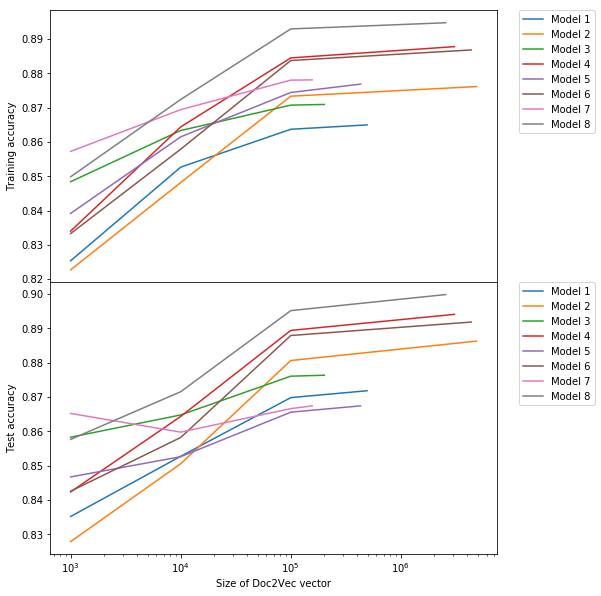

In [27]:
n_models = len(configs)
results_dir = './results/'

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

for i in range(n_models):
    
    dom = np.loadtxt(results_dir + 'BOW_model_%d_dom.csv'%(i+1))
    train_acc = np.loadtxt(results_dir + 'BOW_model_%d_train.csv'%(i+1))
    test_acc = np.loadtxt(results_dir + 'BOW_model_%d_test.csv'%(i+1))
    
    ax1.semilogx(dom, train_acc, 'C%d'%i, label='Model %i'%(i+1))
    ax2.semilogx(dom, test_acc, 'C%d'%i, label='Model %i'%(i+1))

ax2.set_xlabel('Size of Doc2Vec vector')
ax1.set_ylabel('Training accuracy')
ax2.set_ylabel('Test accuracy')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
f.subplots_adjust(hspace=0)

plt.show()
    
    

On voit que la performance obtenue sur les ensembles d'entraînement et de test sont corrélés avec la taille du vocabulaire utilisée. Cependant, on remarque que les progrès obtenus lorsque la taille du vocabulaire est plus grande que 100000 est beaucoup moins importante. Ceci est dû au fait que les mots qui apparaîssent moins fréquemment que les 100000 mots les plus fréquents sont très rares. On remarque aussi que les modèles 4 (bigram + tokenizer), 6 (bigram + stemmer) et 8 (bigram, tokenizer et stemmer) sont ceux qui rapportent les meilleurs résultats, le modèle 8 étant le meilleur avec un peu plus de 89% de précision obtenue sur les ensembles d'entraînement et de test pour un vocabulaire de 100000 mots. L'utilisation des différentes techniques de prétraitement est donc très utile pour améliorer les performances de l'algorithme. Les modèles utilisant les bigrammes sont ceux qui performent le plus, et plus on rajoute d'étape de prétraitement additionnelle, plus la performance augmente.

__QUESTION 5__: Pour l'approche Doc2Vec, tracez sur un même graphique les précisions obtenues sur l'ensemble d'entraînement et de test, pour chaque option de prétraitement, en faisant varier le nombre de features (vec_size) (au moins :4, 8, 64, 256). En résumé, un total de 6 courbes avec la précision en y, et la taille du vecteur en x). __Commentez les résultats__.

In [ ]:
# Les modèles sont numerotés en ordre croissant, de 1 à 8.
configs = [{"use_Doc2Vec":True, "use_bigram":False, "use_nltk_tok":False, "use_stemmer":False,},
           {"use_Doc2Vec":True, "use_bigram":True,  "use_nltk_tok":False, "use_stemmer":False,},
           {"use_Doc2Vec":True, "use_bigram":False, "use_nltk_tok":True,  "use_stemmer":False,},
           {"use_Doc2Vec":True, "use_bigram":True,  "use_nltk_tok":True,  "use_stemmer":False,},
           {"use_Doc2Vec":True, "use_bigram":False, "use_nltk_tok":False, "use_stemmer":True,},
           {"use_Doc2Vec":True, "use_bigram":True,  "use_nltk_tok":False, "use_stemmer":True,},
           {"use_Doc2Vec":True, "use_bigram":False, "use_nltk_tok":True,  "use_stemmer":True,},
           {"use_Doc2Vec":True, "use_bigram":True,  "use_nltk_tok":True,  "use_stemmer":True,}]

# vec_sizes = [4, 8, 64, 256]
vec_sizes = [4, 8, 16, 32, 64, 128, 256]

i = 0

for kwargs in configs:
    
    dom = []
    train_acc = []
    test_acc = []
    
    for vec_size in vec_sizes:
        
        X_train_vec, X_test_vec = prepare_data(X_unsup, X_train, X_test, **kwargs)
        train_score, test_score = Classifier(X_train_vec, y_train, X_test_vec, y_test)
        
        dom.append(vec_size)
        train_acc.append(train_score)
        test_acc.append(test_score)
        
    # Plotting results
    plt.semilogx(dom, train_acc, 'C%do-'%i, label='Model %d - train acc'%(i+1))
    plt.semilogx(dom, test_acc, 'C%dv-'%i, label='Model %d - test acc'%(i+1))
    
    # Saving results in file
    np.savetxt(results_dir + 'D2V_model_%d_dom.csv'%(i+1), np.array(dom))
    np.savetxt(results_dir + 'D2V_model_%d_train.csv'%(i+1), np.array(train_acc))
    np.savetxt(results_dir + 'D2V_model_%d_test.csv'%(i+1), np.array(test_acc))
    
    i += 1

plt.xlabel('Size of Doc2Vec vector')
plt.ylabel('Accuracy')
plt.legend(fancybox=True)
plt.show()

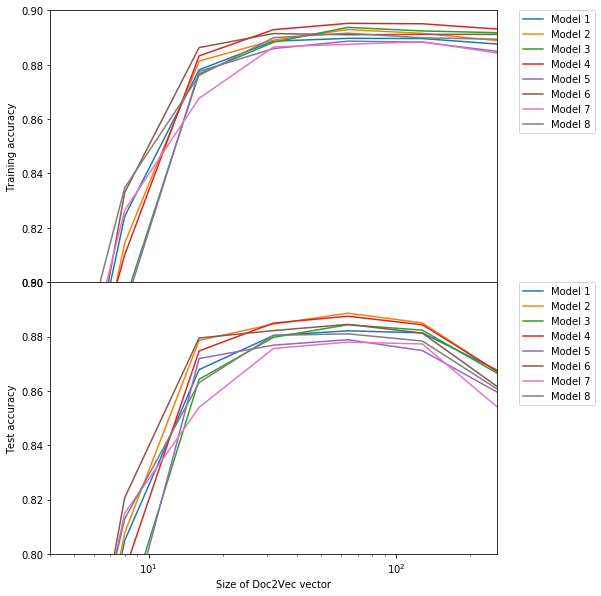

In [35]:
n_models = len(configs)
results_dir = './results/'

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

for i in range(n_models):
    
    dom = np.loadtxt(results_dir + 'D2V_model_%d_dom.csv'%(i+1))
    train_acc = np.loadtxt(results_dir + 'D2V_model_%d_train.csv'%(i+1))
    test_acc = np.loadtxt(results_dir + 'D2V_model_%d_test.csv'%(i+1))
            
    ax1.semilogx(dom, train_acc, 'C%d'%i, label='Model %i'%(i+1))
    ax2.semilogx(dom, test_acc, 'C%d'%i, label='Model %i'%(i+1))

ax2.set_xlabel('Size of Doc2Vec vector')
ax1.set_ylabel('Training accuracy')
ax2.set_ylabel('Test accuracy')
ax1.axis([4, 256, 0.8, 0.90])
ax2.axis([4, 256, 0.8, 0.90])
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
f.subplots_adjust(hspace=0)

plt.show()

On voit que la performance des divers algorithmes semble moins bien définie avec l'approche Doc2Vec. Cependant, on voit que les modèles 2 (bigram) et 4 (bigram + tokenizer) sont ceux qui performent le mieux pour des tailles de embedding de 32, 64 et 128. De plus, la performance obtenue par les modèles pour une taille d'embedding de 4 est très basse (~68 à 73 %), ce qui fait que nous avons été obligé de les couper de la figure pour observer les résultats plus précisément. Pour cette approche aussi, l'effet d'utiliser des bigrammes aide la performance. L'effet d'utiliser un tokenizer ou un stemmer a cependant beaucoup moins d'effet sur les résultats finaux.

__BONUS__: Vous pouvez aussi faire varier les autres paramètres du Doc2Vec (dm, negative, hs, min_count, window) et étudier leurs impacts sur les résultats à l'aide de courbes

---------------------------------
### Bonus


Ayant observé que le *preprocessing* peut avoir un grand effet sur la performance d'un algorithme, on peut aussi essayer de faire des gains au niveau de la précision en substituant le classifieur par un autre algorithme d'apprentissage possédant une plus grande capacité. Nous avons donc choisi de tester certaines des meilleures configurations obtenues avec un réseau de neurones profond de type MLP.

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader
import sys

use_cuda = torch.cuda.is_available()
batch_size = 32

In [10]:
class NNClassifier(nn.Module):
    
    def __init__(self, input_size, output_size, h1=1000, h2=1000):
        super(NNClassifier, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.h1 = h1
        self.h2 = h2
        
        self.mdl = nn.Sequential(
#             nn.Dropout(p=0.2)
            nn.Linear(input_size, h1),
#             nn.Dropout(),
            nn.Linear(h1, h2),
#             nn.Dropout(),
            nn.Linear(h2, output_size)
        )
    
    def forward(self, x):
        return self.mdl(x)

In [24]:
def train(model, train_loader, test_loader, n_epochs=10, learning_rate=1e-3):
    
    if use_cuda:
        model = model.cuda()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    
    loss_tracker = []
    train_acc_tracker = []
    test_acc_tracker = []
    
    for epoch in range(n_epochs):
        
        model.train()
        
        epoch_loss = 0
        n_correct = 0
        n_examples = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            
            optimizer.zero_grad()

            inputs, targets = Variable(inputs), Variable(targets)
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            n_examples += len(inputs)
            predictions = (torch.sign(outputs) + 1) / 2
            n_correct += torch.sum(torch.eq(predictions, targets)).item()
            
            # evaluating performance 10 times per epoch
            if batch_idx % (len(train_loader) // 10) == 0:
                if batch_idx == 0:
                    train_acc_tracker.append((n_correct / n_examples) * 100)
                test_acc_tracker.append(evaluate(model, test_loader))
        
        loss_tracker.append(epoch_loss / len(train_loader))
        train_acc = (n_correct / n_examples) * 100
        test_acc = evaluate(model, test_loader)
        train_acc_tracker.append(train_acc)
        
        print("Epoch : %d ----- Loss : %.2f ----- Train acc : %.2f%% ----- Test acc : %.2f%%" % (epoch, loss_tracker[-1], train_acc, test_acc))

    return loss_tracker, train_acc_tracker, test_acc_tracker

In [12]:
def evaluate(model, dataloader):
    
    if use_cuda:
        model = model.cuda()
        
    model.eval() 
    
    n_correct = 0
    n_examples = 0
        
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        
        inputs, targets = Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        outputs = model(inputs)
        
        tmp = len(inputs)
        n_examples += tmp
        predictions = (torch.sign(outputs) + 1) / 2
        tmp = torch.sum(torch.eq(predictions, targets)).item()
        n_correct += tmp
        
    acc = (n_correct / n_examples) * 100
        
    return acc
        

In [13]:
from scipy.sparse import find

def sparse2torch(tensor):
    
    x_id, y_id, val = find(tensor)
    id = np.dstack((y_id, x_id))[0].T
    id = torch.from_numpy(id).long()

    val = torch.from_numpy(val).float()
    new_tensor = torch.sparse.FloatTensor(id, val)
    
    new_tensor = new_tensor.to_dense().t()
    
    return new_tensor

#### Expériences avec BAG-OF-WORDS

Pour l'approche bag-of-word, on remarque d'après la question 4 que les meilleurs résultats obtenues sont avec les modèles 4, 6 et 8 pour une certaine taille de vocabulaire. Puisque nous avons utilisé PyTorch pour construire le réseau de neurones et que les différents modules ne supportent pas encore les opérations sur des matrices *sparse*, nous avons limité nos expériences à de plus petites tailles de vocabulaire (une taille de vocabulaire de 100000 prenait jusqu'à 32 gb de RAM + SWAP). Nous avons donc conduit nos expériences sur une taille de vocabulaire de 10000, ce qui pouvait être manipulé par la machine utilisée et qui pouvait être comparé avec les résultats obtenus par les expériences faites précédemment à la question 4.



In [ ]:
# BOW experiments

configs = [{"use_Doc2Vec":False, "use_bigram":False, "use_nltk_tok":False, "use_stemmer":False,},
           {"use_Doc2Vec":False, "use_bigram":True,  "use_nltk_tok":False, "use_stemmer":False,},
           {"use_Doc2Vec":False, "use_bigram":False, "use_nltk_tok":True,  "use_stemmer":False,},
           {"use_Doc2Vec":False, "use_bigram":True,  "use_nltk_tok":True,  "use_stemmer":False,},
           {"use_Doc2Vec":False, "use_bigram":False, "use_nltk_tok":False, "use_stemmer":True,},
           {"use_Doc2Vec":False, "use_bigram":True,  "use_nltk_tok":False, "use_stemmer":True,},
           {"use_Doc2Vec":False, "use_bigram":False, "use_nltk_tok":True,  "use_stemmer":True,},
           {"use_Doc2Vec":False, "use_bigram":True,  "use_nltk_tok":True,  "use_stemmer":True,}]

for model_id in [4, 6, 8]:
    
    print("Model %d" % model_id)
    
    vocab_size = 10000

    kwargs = configs[model_id-1]
    X_train_vec, X_test_vec = prepare_data(X_unsup, X_train, X_test, **kwargs)

    X_train_vec = sparse2torch(X_train_vec)
    X_test_vec = sparse2torch(X_test_vec)

    y_train_vec = torch.Tensor(y_train).unsqueeze(-1)
    y_test_vec = torch.Tensor(y_test).unsqueeze(-1)

    train_set = TensorDataset(X_train_vec, y_train_vec)
    test_set = TensorDataset(X_test_vec, y_test_vec)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    
    input_size = train_set[0][0].shape[0]

    model = NNClassifier(input_size=input_size, output_size=1)
    loss_tracker, train_acc_tracker, test_acc_tracker = train(model, train_loader, test_loader, n_epochs=5)
    
    np.savetxt(results_dir + 'bow_nn_loss_%d.txt' % model_id, np.array(loss_tracker))
    np.savetxt(results_dir + 'bow_nn_train_acc_%d.txt' % model_id, np.array(train_acc_tracker))
    np.savetxt(results_dir + 'bow_nn_test_acc_%d.txt' % model_id, np.array(test_acc_tracker))

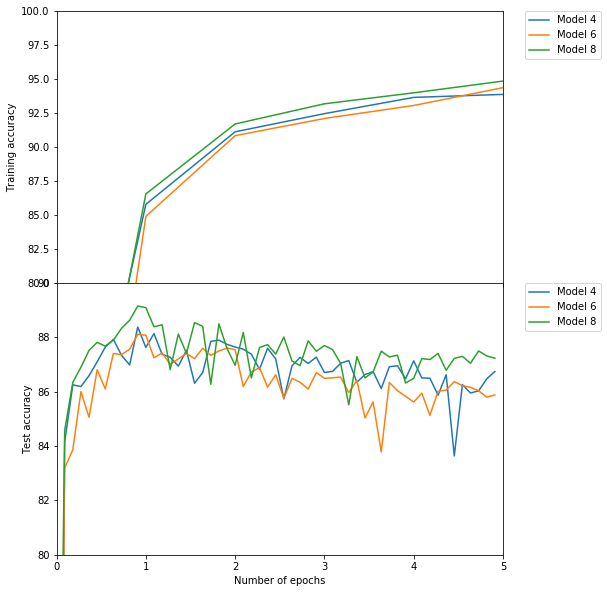

In [31]:
# plot results

results_dir = './results/'

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
color_id = 0
for i in [4, 6, 8]:
    
    dom_train = np.arange(6)
    dom_test = np.arange(55) / 11
    train_acc = np.loadtxt(results_dir + 'bow_nn_train_acc_%d.txt' %i)
    test_acc = np.loadtxt(results_dir + 'bow_nn_test_acc_%d.txt'%i)
            
    ax1.plot(dom_train, train_acc, 'C%d'%color_id, label='Model %i'%(i))
    ax2.plot(dom_test, test_acc, 'C%d'%color_id, label='Model %i'%(i))

    color_id += 1
                           
ax2.set_xlabel('Number of epochs')
ax1.set_ylabel('Training accuracy')
ax2.set_ylabel('Test accuracy')
ax1.axis([0, 5, 80, 100])
ax2.axis([0, 5, 80, 90])
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
f.subplots_adjust(hspace=0)

plt.show()

La figure précédente montre les courbes d'entraînement obtenue pour chacun des modèles testés avec un vocabulaire de 10000, entraîné sur 5 époques. On observe que la meilleure performance obtenue pour chaque type de prétraitement est obtenue après environ 1 époque, après quoi le modèle commence à sur-entraîner le modèle. Il est à noter ici que la performance obtenue sur l'ensemble d'entraînement est calculée à la fin de chaque époque et que la performance sur l'ensemble de test est calculée 10 fois par époque. Encore une fois, les meilleurs résultats sont obtenus avec le modèle 8, alors que les deux approches sont plutôt égales pour l'ensemble des approches.

Les performances obtenues par ces modèles sont similaires à ceux obtenus par le classifieur linéaire de la question 4. Les résultats sont plus élevés d'environ 1 à 2% pour chacun des modèles pour la taille du vocabulaire donnée sur l'ensemble de test, mais les résultats obtenus sur l'ensemble d'entraînement sont plus petits, ce qui nous amène à conclure que la différence entre les performances obtenues pour les deux différents classifieurs est négligeable.

#### Expériences avec DOC2VEC

Pour l'approche Doc2Vec, on remarque que les meilleurs résultats obtenus étaient avec les modèles 2 et 4 pour une taille d'embedding de 32, 64 et 128. Nous avons donc conduit les mêmes expériences avec le nouveau classifieur.

In [ ]:
# D2V experiments

configs = [{"use_Doc2Vec":True, "use_bigram":False, "use_nltk_tok":False, "use_stemmer":False,},
           {"use_Doc2Vec":True, "use_bigram":True,  "use_nltk_tok":False, "use_stemmer":False,},
           {"use_Doc2Vec":True, "use_bigram":False, "use_nltk_tok":True,  "use_stemmer":False,},
           {"use_Doc2Vec":True, "use_bigram":True,  "use_nltk_tok":True,  "use_stemmer":False,},
           {"use_Doc2Vec":True, "use_bigram":False, "use_nltk_tok":False, "use_stemmer":True,},
           {"use_Doc2Vec":True, "use_bigram":True,  "use_nltk_tok":False, "use_stemmer":True,},
           {"use_Doc2Vec":True, "use_bigram":False, "use_nltk_tok":True,  "use_stemmer":True,},
           {"use_Doc2Vec":True, "use_bigram":True,  "use_nltk_tok":True,  "use_stemmer":True,}]

for model_id in [2, 4]:
    for vec_size in [32, 64, 128]:
    
        print("Model %d, Embedding size : %d" % (model_id, vec_size))

        kwargs = configs[model_id-1]
        X_train_vec, X_test_vec = prepare_data(X_unsup, X_train, X_test, **kwargs)

        X_train_vec = torch.Tensor(X_train_vec)
        X_test_vec = torch.Tensor(X_test_vec)

        y_train_vec = torch.Tensor(y_train).unsqueeze(-1)
        y_test_vec = torch.Tensor(y_test).unsqueeze(-1)

        train_set = TensorDataset(X_train_vec, y_train_vec)
        test_set = TensorDataset(X_test_vec, y_test_vec)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=batch_size)

        input_size = train_set[0][0].shape[0]

        model = NNClassifier(input_size=input_size, output_size=1)
        loss_tracker, train_acc_tracker, test_acc_tracker = train(model, train_loader, test_loader, n_epochs=20)

        np.savetxt(results_dir + 'd2v_nn_loss_%d_%d.txt' % (model_id, vec_size), np.array(loss_tracker))
        np.savetxt(results_dir + 'd2v_nn_train_acc_%d_%d.txt' % (model_id, vec_size), np.array(train_acc_tracker))
        np.savetxt(results_dir + 'd2v_nn_test_acc_%d_%d.txt' % (model_id, vec_size), np.array(test_acc_tracker))


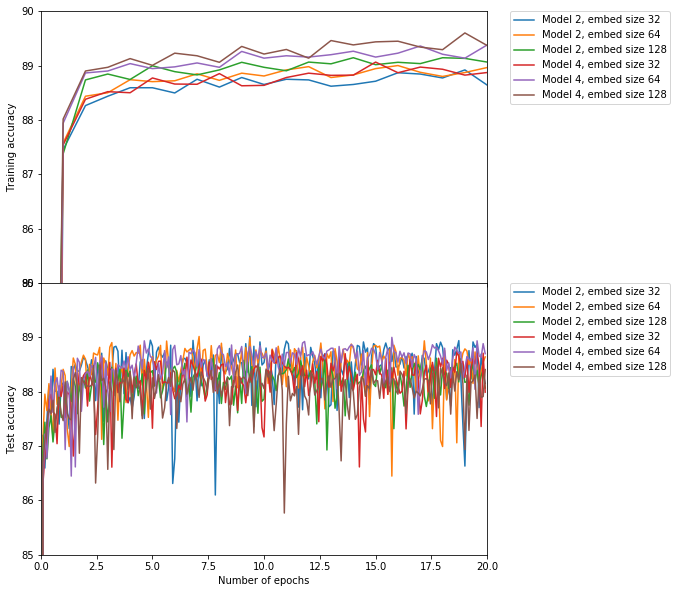

In [39]:
# plot results

results_dir = './results/'

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
color_id = 0
for i in [2, 4]:
    for embed_size in [32, 64, 128]:
    
        dom_train = np.arange(21)
        dom_test = np.arange(11*20) / 11
        train_acc = np.loadtxt(results_dir + 'd2v_nn_train_acc_%d_%d.txt' %(i, embed_size))
        test_acc = np.loadtxt(results_dir + 'd2v_nn_test_acc_%d_%d.txt'%(i, embed_size))

        ax1.plot(dom_train, train_acc, 'C%d'%color_id, label='Model %d, embed size %d'%(i, embed_size))
        ax2.plot(dom_test, test_acc, 'C%d'%color_id, label='Model %d, embed size %d'%(i, embed_size))

        color_id += 1
                           
ax2.set_xlabel('Number of epochs')
ax1.set_ylabel('Training accuracy')
ax2.set_ylabel('Test accuracy')
ax1.axis([0, 20, 85, 90])
ax2.axis([0, 20, 85, 90])
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
f.subplots_adjust(hspace=0)

plt.show()

Une fois de plus, les résultats obtenus à l'aide du réseau de neurones comme classifieur nous donne des résultats très similaires aux résultats obtenus avec le classifieur linéaire (question 5) tant sur l'ensemble d'entraînement que sur l'ensemble de test.

Il est à noter que le réseau de neurones ne semble jamais être en sur-entraînement, contrairement à ce que l'on observait pour les expériences avec le *bag-of-words*. Nous avons aussi fait une recherche d'hyperparamètres, faisant varier la taille des batch (8, 32, 128), le taux d'entraînement (1e-2, 1e-3, 1e-4, 1e-5) et taille des couches cachées (200, 500, 1000), sans jamais obtenir de meilleurs résultats. Il semble donc que les deux catégories de critiques de film (positif ou négatif) sont presque linéairement séparables dans l'espace des embeddings, mais que la portion des critiques étant mal classifiées par nos algorithmes se retrouvent dans une section très bruitée, où il est difficile pour les algorithmes de séparer clairement les deux catégories.

### References

[1] Tomas Mikolov et al., “ Distributed Representations of Words and Phrases and their Compositionality,“CoRR, vol. 1310.4546, 2013. http://arxiv.org/abs/1310.4546

[2] Quoc V. Le et al., “ Distributed Representations of Sentences and Documents,“CoRR, vol. 1405.4053, 2014. http://arxiv.org/abs/1405.4053

[3] Tomas Mikolov et al., “Efficient Estimation of Word Representations in Vector Space,“CoRR, vol. 1301.3781, 2013. http://arxiv.org/abs/1301.3781

[4] https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e

[5] https://machinelearningmastery.com/gentle-introduction-bag-words-model/